In [1]:
import flax.linen as nn

In [2]:
%cd "C://Users//TRETEC//Documents//MVA//S1//[IPGM] Introduction to probabilistic graphical models//Projet//independent_component_analysis"
import optax
from mva_independent_component_analysis.utils.math import logaddexp
from mva_independent_component_analysis.utils.metrics import mean_corr_coef
from mva_independent_component_analysis.vae_and_non_linear_ica_unifying_framework.ivae.nets import IVAE
from optax import adam
from optax import piecewise_constant_schedule, exponential_decay
import jax.numpy as jnp
import jax
from mva_independent_component_analysis.vae_and_non_linear_ica_unifying_framework.ivae.exponential_family import logdensity_normal
import flax
%cd experiments/exp4_ivae_images

c:\Users\TRETEC\Documents\MVA\S1\[IPGM] Introduction to probabilistic graphical models\Projet\independent_component_analysis\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\TRETEC\Documents\MVA\S1\[IPGM] Introduction to probabilistic graphical models\Projet\independent_component_analysis
C:\Users\TRETEC\Documents\MVA\S1\[IPGM] Introduction to probabilistic graphical models\Projet\independent_component_analysis\experiments\exp4_ivae_images


c:\Users\TRETEC\Documents\MVA\S1\[IPGM] Introduction to probabilistic graphical models\Projet\independent_component_analysis\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import os, torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
import tqdm

# seed number for reproducibility
seed = 0

# make result folder
result_path = './results' 
os.makedirs(result_path, exist_ok=True)
print('result_path: ', result_path)

# load and pre-process the MNIST dataset
onehot_enc = OneHotEncoder(handle_unknown='ignore')
transform = Compose([ToTensor(),
                     Lambda(lambda x: x.view(1, 28, 28)),
                     Lambda(lambda x: x.transpose(1, 2))])

mnist_train = torchvision.datasets.MNIST(root='./MNIST',
                                         train=True,
                                         download=True,
                                         transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./MNIST',
                                        train=False,
                                        download=True,
                                        transform=transform)

x_train, u_train = mnist_train.data, mnist_train.targets
x_test, u_test = mnist_test.data, mnist_test.targets

x_train = np.reshape(x_train, (-1, 28*28))/255.0
x_test = np.reshape(x_test, (-1, 28*28))/255.0
u_train = onehot_enc.fit_transform(u_train.reshape(-1, 1)).toarray()
u_test = onehot_enc.fit_transform(u_test.reshape(-1, 1)).toarray()


result_path:  ./results


In [4]:
x_train_numpy=x_train.numpy()
x_test_numpy=x_test.numpy()


In [5]:
model_cfg = {
        'n_layers': 3,
        'activation': lambda x: nn.tanh(x) + 0.1 * x,
        'hidden_dim': 100}
learning_cfg = {
        'a': 100,
        'b': 1,
        'c': 0,
        'd': 10,
        'lr': 1e-2,
        'batch_size': 60,
        'epochs': 200,
    }

In [6]:
def create_batch(OP_key, X, U, batch_size):
    n = X.shape[0] // batch_size

    def split_and_shuffle(key, x):
        x = jnp.asarray(jnp.split(x, n))
        x = jax.random.permutation(key, x)
        return x

    return split_and_shuffle(OP_key, X), split_and_shuffle(OP_key, U)

In [7]:
def train_and_evaluate(OP_key, X, U, latent_dim, model_cfg, learning_cfg):

    data_dim, aux_dim = X.shape[1], U.shape[1]
    model_cfg.update({'data_dim': data_dim, 'latent_dim' : latent_dim, 'aux_dim': aux_dim})

    # learning parameters
    lr = learning_cfg.pop('lr', 1e-2)
    batch_size = learning_cfg.pop('batch_size', 60)
    epochs = learning_cfg.pop('epochs', 200)
    # fixed Gaussian noise: \varepsilon ~ N(0, sigma^2Id)
    var_decoder = 0.1

    N = X.shape[0]
    assert N % batch_size == 0
    n = N // batch_size
    key1, key = jax.random.split(OP_key, 2)
    batches = create_batch(key1, X, U, batch_size)

    # order: x, s, u
    x_shape, u_shape = batches[0][0].shape, batches[1][0].shape

    model = IVAE(**model_cfg)
    variables = model.init(key, key=key1, x=jnp.empty(x_shape), u=jnp.empty(u_shape))
    state, params = flax.core.pop(variables, 'params')
    del variables
    # scheduler = piecewise_constant_schedule(lr, {int(0.8 * epochs): 0.8})
    scheduler = exponential_decay(lr, 1000, 0.8)
    optimizer = adam(scheduler)
    opt_state = optimizer.init(params)
    batch_keys = jax.random.split(key, n)

    def train_step(state, opt_state, params, z_rng_batch, x_batch, u_batch, a, b, c, d):
        """
        See: https://flax.readthedocs.io/en/latest/guides/flax_fundamentals/state_params.html
             https://github.com/ilkhem/iVAE
             Assuming z \mid u Gaussian-prior.
        """

        def batch_loss(params):
            def loss_fn(z_rng, x, u):
                f, g, v, z, l = model.apply(
                    {'params': params}, z_rng, x, u  # **state
                )
                M, d_latent = z.shape
                logpx = jnp.sum(logdensity_normal(x, f, var_decoder), axis=-1)
                logqs_cux = jnp.sum(logdensity_normal(z, g, v), axis=-1)
                logps_cu = jnp.sum(logdensity_normal(z, 0., l), axis=-1)

                logqs_tmp = logdensity_normal(z.reshape(M, 1, d_latent), g.reshape(1, M, d_latent),
                                              v.reshape(1, M, d_latent))
                logqs = logaddexp(jnp.sum(logqs_tmp, axis=-1), axis=1) - jnp.log(M * N)
                logqs_i = jnp.sum(logaddexp(logqs_tmp, axis=1) - jnp.log(M * N), axis=-1)

                elbo = -jnp.mean(
                    (a * logpx - b * (logqs_cux - logqs) - c * (logqs - logqs_i) - d * (logqs_i - logps_cu)))
                return elbo, z

            loss, updated_state = jax.vmap(loss_fn, out_axes=(0, 0))(z_rng_batch, x_batch,
                                                                     u_batch)  # out_axes = (0, None)?
            return loss.mean(), updated_state

        (loss, updated_state), grads = jax.value_and_grad(
            batch_loss, has_aux=True,
        )(params)
        updates, opt_state = optimizer.update(grads, opt_state, params=params)
        params = optax.apply_updates(params, updates)
        return opt_state, params, updated_state, loss

    for epoch in range(epochs):
        opt_state, params, state, loss = train_step(state, opt_state, params, batch_keys, batches[0], batches[1],
                                                    **learning_cfg)
        print(f"Epoch: {epoch}; Loss: {loss}")
    return model,params,state


In [8]:
OP_key = jax.random.PRNGKey(106)
model, params, state = train_and_evaluate(OP_key, x_train_numpy, u_train, 16, model_cfg, learning_cfg)

Epoch: 0; Loss: 169613.15625
Epoch: 1; Loss: 108431.046875
Epoch: 2; Loss: 71384.65625
Epoch: 3; Loss: 42420.88671875
Epoch: 4; Loss: 57921.10546875
Epoch: 5; Loss: 44407.375
Epoch: 6; Loss: 43234.40234375
Epoch: 7; Loss: 89487.0234375
Epoch: 8; Loss: 34959.35546875
Epoch: 9; Loss: 29242.609375
Epoch: 10; Loss: 23230.185546875
Epoch: 11; Loss: 18902.8359375
Epoch: 12; Loss: 18962.77734375
Epoch: 13; Loss: 15339.6865234375
Epoch: 14; Loss: 11457.2109375
Epoch: 15; Loss: 11504.0986328125
Epoch: 16; Loss: 18028.9921875
Epoch: 17; Loss: 23722.572265625
Epoch: 18; Loss: 19520.068359375
Epoch: 19; Loss: 12135.2275390625
Epoch: 20; Loss: 13175.185546875
Epoch: 21; Loss: 12309.716796875
Epoch: 22; Loss: 10191.2802734375
Epoch: 23; Loss: 10795.240234375
Epoch: 24; Loss: 8871.2509765625
Epoch: 25; Loss: 7766.12451171875
Epoch: 26; Loss: 7596.748046875
Epoch: 27; Loss: 8248.4990234375
Epoch: 28; Loss: 7424.12646484375
Epoch: 29; Loss: 6617.3564453125
Epoch: 30; Loss: 5798.3837890625
Epoch: 31; Lo

In [9]:
model

IVAE(
    # attributes
    data_dim = 784
    latent_dim = 16
    aux_dim = 10
    n_layers = 3
    activation = <lambda>
    hidden_dim = 100
)

In [16]:
z=state.reshape(-1,16)

In [17]:
z.shape

(60000, 16)

In [12]:
np.argmax(u_train, axis=1).shape

(60000,)

[Text(0.5, 1.0, 'T-SNE projection')]

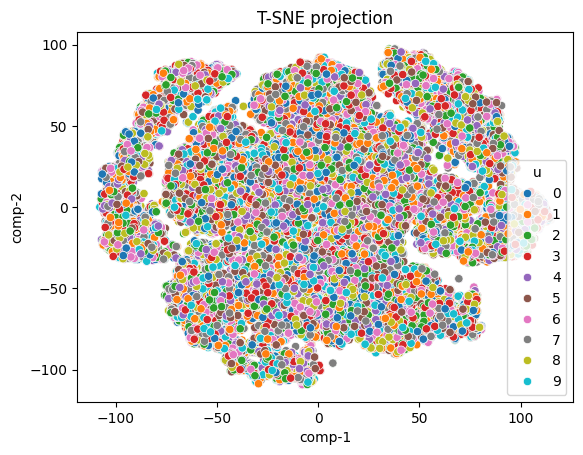

In [20]:
tsne_test = TSNE(n_components=2).fit_transform(z)

df = pd.DataFrame()
df["u"] = np.argmax(u_train, axis=1)
df["comp-1"], df["comp-2"] = tsne_test[:,0], tsne_test[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue="u",
                palette=sns.color_palette(),
                data=df).set(title="T-SNE projection")

In [25]:
params

{'f': {'layers_0': {'bias': Array([ 7.65590742e-02,  4.32081334e-03, -2.59420108e-02,  1.86354276e-02,
           1.28940539e-02,  1.83650013e-02,  1.46592176e-02, -5.90044782e-02,
          -3.54805514e-02, -6.56124298e-03, -2.47466341e-02, -3.30278240e-02,
          -3.93875502e-03,  3.60811017e-02,  3.83222708e-03,  4.82800715e-02,
          -1.07896410e-01,  6.04128465e-03, -3.39946710e-02, -1.90263111e-02,
           5.17738191e-03, -1.00231301e-02, -7.61392936e-02, -3.07112839e-03,
          -7.16638491e-02,  1.45198423e-02,  6.41065463e-02, -9.58121382e-03,
          -3.11358068e-02, -2.13660672e-02,  2.68705804e-02, -3.62132527e-02,
           3.28866742e-03, -8.49354547e-03,  2.18399242e-02, -1.00186029e-02,
           4.12538424e-02, -2.20544785e-02,  2.01559272e-02,  3.86448856e-03,
           1.18205613e-02, -2.49810424e-02,  1.32383388e-02, -9.40473936e-03,
           9.13189258e-03,  5.72562106e-02, -1.53894387e-02,  1.18381772e-02,
           7.30701610e-02,  1.84066165e

In [29]:
params['f']['layers_0']['kernel'].shape

(16, 100)

In [44]:
reconstructed = model.apply({'params' : params}, OP_key, None, None, z, decoder = True)

IndexError: tuple index out of range

In [32]:
jnp.shape(z)[-1]

16